In [2]:
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as pat
import scipy.linalg as sl
import numpy as np
import librosa
import librosa.display
import IPython.display as ipd

from copy import deepcopy
import tqdm

# additionally requires libcpab (https://github.com/SkafteNicki/libcpab)
import nwarp

In [3]:
def mfcc(filename, delta=False, segments=False, start=None, stop=None):
    y, sr = librosa.core.load(filename, sr=None)
    if segments:
        y = y[start:stop]

    # stretch samples so that K << T
    y = librosa.effects.time_stretch(y, 1/250)

    # Mel-frequency cepstral coefficients 1-12
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=12, hop_length=512, n_mels=128, fmax=sr/2)
    if delta:
        mfccs = np.vstack([mfccs, librosa.feature.delta(mfccs), librosa.feature.delta(mfccs, order=2)])

    # normalize
    mfccs = (mfccs.transpose()-mfccs.mean(axis=1))/mfccs.std(axis=1)
    mfccs = mfccs.transpose()

    return torch.from_numpy(np.array(mfccs)[np.newaxis].swapaxes(1,2))

def play_sequence(filepath, start, end, stretch=1):
    '''
    makes WAV playable in jupyter, returns array with amplitude and sample rate from file.
    Option to stretch sound. stretch < 1 -> longer sample.
    '''
    y, sr = librosa.load(filepath, sr=None)
    y = librosa.effects.time_stretch(y, stretch)
    ipd.display(ipd.Audio(y[start:end], rate=sr))
    return y, sr

def almat_transition_points(almat):
    '''
    find the transition points in the alignment matrices, 
    padding to add start and stop "transition", and scale to [0,1]
    '''
    segments = (almat[:, :-1, :]
           - almat[:, 1:, :]).abs().sum(axis=2).sign().nonzero()[:, 1:].view(almat.shape[0], -1) / float(almat.shape[1])
    return np.pad(segments[0], pad_width=(1,1), constant_values=(0,1))

def alignment(transitionPointsEstimated, transitionPointsTrue):
    '''
    distance from each true phoneme transition to the closest predicted one
    '''
    distances = np.abs(transitionPointsEstimated - transitionPointsTrue[:, None])
    return distances.min(axis=1)

### Load and preprocess data

In [3]:
# Please obtain the TIMIT corpus from https://catalog.ldc.upenn.edu/LDC93S1.

filename  = "TIMIT/SI1086" # the full path in the corpus is "timit/TRAIN/DR3/FALK0/SI1086"
phn = pd.read_csv(filename + ".PHN", delimiter=' ', header=None)
print(phn.head(20))

# we only use part of the speech signal
sequence       = [8, 18]
segments       = sequence[1] - sequence[0]
sequenceStart  = phn.iloc[sequence[0], 0]
sequenceEnd    = phn.iloc[sequence[1], 0]

y, sr = play_sequence(filename + '.WAV', sequenceStart, sequenceEnd)
toleranceLevel = sr * 0.02 / (sequenceEnd - sequenceStart)

# true transition points, scaled to [0,1] and MFCCs
transitionPointsTrue = np.array([phn.iloc[i, 0] for i in range(sequence[0], sequence[1]+1)])
transitionPointsTrue = (transitionPointsTrue - sequenceStart) / (sequenceEnd - sequenceStart)
transitionPointsTrue = transitionPointsTrue[1:-1]
y_train = mfcc(filename + ".WAV", 
                segments=True, 
                delta=False,
                start=sequenceStart, 
                stop=sequenceEnd)

N, T, Dout = y_train.shape
print(f"N = {N}\n"
      f"T = {T}\n"
      f"Dout = {Dout}")

        0      1    2
0       0   5800   h#
1    5800   9800  pau
2    9800  10120   dh
3   10120  11613   eh
4   11613  12440    n
5   12440  12600   dh
6   12600  13560   ix
7   13560  14600  kcl
8   14600  15640    k
9   15640  16710   ao
10  16710  17503    r
11  17503  18673   iy
12  18673  21080   aa
13  21080  22200  gcl
14  22200  22600    g
15  22600  23320  axr
16  23320  25400    f
17  25400  26920   er
18  26920  28532    m
19  28532  29535   ah


N = 1
T = 6016
Dout = 12


### Define model

In [4]:
# PIECEWISE CONSTANT: simply output the warped parameter vector
# TSP-based parameter warping with constant mode vector
K = len(transitionPointsTrue)+1 # number of segments
Dparamg = 0 # number of global parameters (same in every segment)
Dparaml = Dout # number of local parameters (different in every segment)
paramwarp = nwarp.ParameterWarp(K, Dparamg, Dparaml,
               nwarp.TSPStepWarp(nwarp.Constant((K-1,)),
                                 width=0.125, power=16.,
                                 min_step=0.0001, max_step=0.9999))

print(paramwarp)

ParameterWarp(
  (warp): TSPStepWarp(
    (loc_net): Constant()
  )
  (resample): Resample()
)


### Training

In [5]:
n_restarts    =  10 # number of randomized restarts
n_epochs      = 300 # total number of epochs
n_epochs_hard = 100 # use hard segmentation for the last X epochs
show_plots    = False
loss_fn       = nn.MSELoss(reduction='mean')

In [6]:
best_loss = np.inf
for r in range(n_restarts):
    # reset everything
    optimizer = torch.optim.Adam(paramwarp.parameters(), lr=1e-1)
    param_norm = []
    grad_norm = []
    train_losses = []
    resample_kernel = "linear"
    epoch_counter = tqdm.tqdm(range(n_epochs), desc=f"restart {(r+1):2d}/{n_restarts:2d}")

    # initialize parameters
    _ = paramwarp.apply(nwarp.reset_parameters)
    nn.init.uniform_(paramwarp.warp.loc_net.const, -1., 0.) # segmentation

    # perform training
    paramwarp.train()
    for epoch in epoch_counter:
        optimizer.zero_grad()
        
        if epoch == n_epochs - n_epochs_hard:
            resample_kernel = "integer"

        param_hat_train = paramwarp(y_train, resample_kernel=resample_kernel)[0]
        y_hat_train = param_hat_train

        loss = loss_fn(y_hat_train, y_train)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        param_norm.append([sl.norm(p.detach()) for p in paramwarp.parameters() if len(p)>0])
        grad_norm.append([sl.norm(p.grad.detach()) for p in paramwarp.parameters() if len(p)>0])
        epoch_counter.set_postfix({"max": f"{max(train_losses):.4f}", "cur": f"{loss.item():.4f}"})

    if train_losses[-1] < best_loss:
        best_paramwarp_state = deepcopy(paramwarp.state_dict())
        best_loss = train_losses[-1]

    if show_plots:
        plt.figure(figsize=(15,2))
        plt.subplot(131)
        plt.title("loss")
        plt.ylim(np.min(train_losses), np.percentile(train_losses, 95))
        plt.plot(train_losses)

        plt.subplot(132)
        plt.title("parameter norm")
        lines = plt.plot(np.array(param_norm)/np.array(param_norm).max(axis=0))
        plt.legend(lines, [" x ".join([str(d) for d in p.size()]) for p in paramwarp.parameters() if len(p)>0])

        plt.subplot(133)
        plt.title("gradient norm")
        normalized_grad_norm = np.array(grad_norm)/np.array(grad_norm).max(axis=0)
        lines = plt.plot(normalized_grad_norm)
        plt.legend(lines, [" x ".join([str(d) for d in p.size()]) for p in paramwarp.parameters() if len(p)>0])
        plt.ylim(np.min(normalized_grad_norm), np.percentile(normalized_grad_norm, 95))

        plt.show()

paramwarp.eval()
paramwarp.load_state_dict(best_paramwarp_state)
print(f"best loss = {best_loss:.4f}")

restart 10/10: 100%|██████████| 300/300 [00:16<00:00, 17.70it/s, max=1.0220, cur=0.1851]

best loss = 0.1851


### Evaluation

In [7]:
param_hat_train, almat_hat_train, gamma_hat_train = paramwarp(y_train, resample_kernel=resample_kernel)
y_hat_train = param_hat_train

transitionPointsEstimated = almat_transition_points(almat_hat_train)[1:-1]
yEstimated   = np.zeros_like(transitionPointsEstimated)
yTrue        = np.ones_like(transitionPointsTrue)

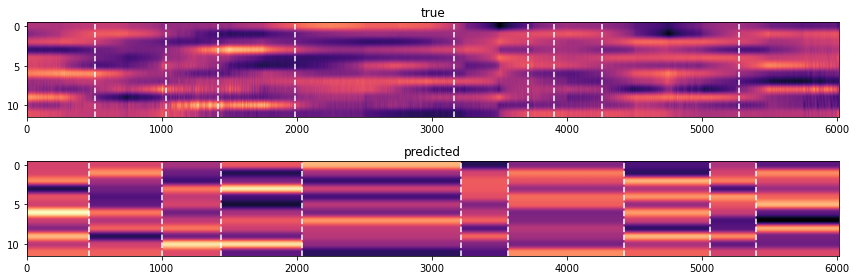

In [8]:
inp = np.array(y_train[0, :,:12].t().detach())
out = np.array(y_hat_train[0, :, :12].t().detach())
plt.figure(figsize=(12,4))
plt.subplot(211, title="true")
plt.imshow(inp, aspect='auto', cmap="magma")
for xc in transitionPointsTrue*6016:
    plt.axvline(x=xc, color='w', linestyle='--')
    
plt.subplot(212, title="predicted")
plt.imshow(out, aspect='auto', cmap="magma")
for xc in transitionPointsEstimated*6016:
    plt.axvline(x=xc, color='w', linestyle='--')
    
plt.tight_layout()
plt.show()

In [9]:
criterion = np.sum(alignment(transitionPointsEstimated, transitionPointsTrue) < toleranceLevel)
print(f"{criterion} out of {len(transitionPointsTrue)} segment boundaries detected with a tolerance of 20 ms")

random_trials = 10000
random_detectors = np.array([np.sum(alignment(np.sort(np.random.uniform(size=9)), transitionPointsTrue) < toleranceLevel) for i in range(random_trials)])
random_worse = np.sum(random_detectors < criterion)
print(f"random segmentation is worse in {random_worse} out of {random_trials} trials ({random_worse/random_trials*100}%)")

7 out of 9 segment boundaries detected with a tolerance of 20 ms
random segmentation is worse in 9932 out of 10000 trials (99.32%)
